In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [2]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [3]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [4]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [5]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [6]:
env.render()

|- - X|
|- - -|
|- - -|



In [7]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [8]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [9]:
env.render()

|- - X|
|- O -|
|- - -|



In [10]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [11]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [12]:
env.reward(player='X')

0

In [13]:
env.reward(player='O')

0

An example of finishing the game:

In [14]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [15]:
env.render()

|X X X|
|O O -|
|- - -|



In [16]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [17]:
env.reward(player='X')

1

In [18]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [19]:
env.reset();

In [20]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [21]:
opt_player.act(env.grid)

(2, 2)

In [22]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [23]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|- - X|
|- X O|
|X O -|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|- X O|
|- X O|
|X - O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O X|
|- X X|
|O - X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O X|
|- X -|
|X - -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|X O O|
|- X -|
|- - X|



### An example of optimal player playing against optimal player

In [24]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|O X X|
|X O O|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|O X X|
|X O O|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|O X X|
|O X O|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X X O|
|O O X|
|X O X|



test

In [25]:
Turns = np.array(['X','O'])
X_reward = []
O_reward = []
for i in range(1000):
    env.reset()
    grid, _, __ = env.observe()
    player_X = OptimalPlayer(epsilon=0., player='X')
    player_O = OptimalPlayer(epsilon=1., player='O')
    for j in range(9):
        if env.current_player == player_X.player:
            move = player_X.act(grid)
        else:
            move = player_O.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            X_reward.append(env.reward(player='X'))
            O_reward.append(env.reward(player='O'))
            env.reset()
            break
print('Reward X = ' +  str(sum(X_reward)))
print('Reward O = ' +  str(sum(O_reward)))

Reward X = 961
Reward O = -961


# Q-Learning

### 2.1

In [26]:
step_size = 0.05
discount = 0.99
epsilon = 0.1

In [27]:
Q_table = {str(np.zeros((3,3))) : np.zeros(9)}
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [28]:
def Q_actions(s):
    # s is a np grid
    if(Q_table.get(str(s),'a') == 'a'):
        Q_table[str(s)] = np.where(s.flatten() == 0, s.flatten(), np.nan)
    return Q_table[str(s)]

In [29]:
def Q(s, a):
    return Q_actions(str(s))[a]

In [30]:
env.reset()
env.step(0)

(array([[1., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [31]:
Q_actions(env.grid)

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [32]:
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}

In [33]:
# let two random play to fill out a bit of the table
for i in range(100):
    env.reset()
    grid, _, __ = env.observe()
    player_X = OptimalPlayer(epsilon=1., player='X')
    player_O = OptimalPlayer(epsilon=1., player='O')
    for j in range(9):
        if env.current_player == player_X.player:
            move = player_X.act(grid)
        else:
            move = player_O.act(grid)

        grid, end, winner = env.step(move, print_grid=False)
        Q_actions(env.grid)

        if end:
            env.reset()
            break

In [34]:
len(Q_table)

577

In [35]:
Q_table

{'[[0. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 '[[1. 0. 0.]\n [0. 0. 0.]\n [0. 0. 0.]]': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 '[[ 1.  0.  0.]\n [ 0.  0.  0.]\n [ 0. -1.  0.]]': array([nan,  0.,  0.,  0.,  0.,  0.,  0., nan,  0.]),
 '[[ 1.  0.  0.]\n [ 0.  0.  1.]\n [ 0. -1.  0.]]': array([nan,  0.,  0.,  0.,  0., nan,  0., nan,  0.]),
 '[[ 1.  0.  0.]\n [ 0. -1.  1.]\n [ 0. -1.  0.]]': array([nan,  0.,  0.,  0., nan, nan,  0., nan,  0.]),
 '[[ 1.  0.  1.]\n [ 0. -1.  1.]\n [ 0. -1.  0.]]': array([nan,  0., nan,  0., nan, nan,  0., nan,  0.]),
 '[[ 1.  0.  1.]\n [-1. -1.  1.]\n [ 0. -1.  0.]]': array([nan,  0., nan, nan, nan, nan,  0., nan,  0.]),
 '[[ 1.  0.  1.]\n [-1. -1.  1.]\n [ 1. -1.  0.]]': array([nan,  0., nan, nan, nan, nan, nan, nan,  0.]),
 '[[ 1.  0.  1.]\n [-1. -1.  1.]\n [ 1. -1. -1.]]': array([nan,  0., nan, nan, nan, nan, nan, nan, nan]),
 '[[ 1.  1.  1.]\n [-1. -1.  1.]\n [ 1. -1. -1.]]': array([nan, nan, nan,

In [38]:
def epsilon_action(q_vals, eps):
    if (np.random.default_rng().random() > eps):
        #random move
        #gets random non-nan index
        return np.random.choice([x[0] for x in enumerate(q_vals) if not np.isnan(x[1])])
    else:
        #first best move
        return np.nanargmax(q_vals)

In [42]:
Turns = np.array(['X','O'])
opt_reward = []
learn_reward = []
for i in range(1000):
    moves = []
    
    env.reset()
    grid, _, __ = env.observe()
    player_opt = OptimalPlayer(epsilon=0.5, player=Turns[i%2])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            # get the q values
            q_vals = Q_actions(env.grid)
            # choose a move
            move = epsilon_action(q_vals, epsilon)
            
            #add position and move to array
            moves.append((env.grid, move))
            
            # get move in 2d format
            move = (move//3, move%3)
            
        grid, end, winner = env.step(move)
        
        # update the Q-values
        if env.current_player != player_opt.player:
            reward = env.reward(player=Turns[(i+1)%2])
            num_moves = len(moves)
            for i in range(num_moves - 1):
                position = moves[i][0]
                action = moves[i][1]
                Q_next_max = np.nanmax(Q_actions(moves[i + 1][0]))
                Q_table[str(position)][action] += step_size * (reward + discount * Q_next_max - Q_table[str(position)][action])
        
        if end:
            # add rewards to arrays
            opt_reward.append(env.reward(player=Turns[i%2]))
            learn_reward.append(env.reward(player=Turns[(i+1)%2]))
            env.reset()
            break
print('Reward opt = ' +  str(sum(opt_reward)))
print('Reward learn = ' +  str(sum(learn_reward)))

C:\Users\Ferdi\.conda\envs\CS456\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: All-NaN slice encountered


Reward opt = 1146
Reward learn = -1146


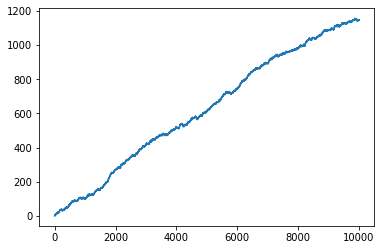

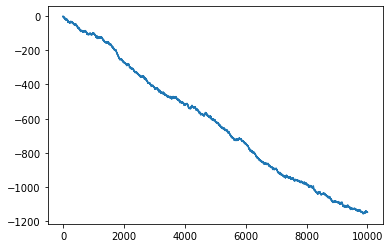

In [43]:
plt.plot(np.cumsum(opt_reward))
plt.show()
plt.plot(np.cumsum(learn_reward))
plt.show()